```
Dataset
In this homework, we will use the Students Performance in 2024 JAMB dataset from Kaggle.
wget https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv
```

In [5]:
!curl -O https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text


In [17]:
df = pd.read_csv('jamb_exam_results.csv')

In [18]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [21]:
del df['student_id']

In [22]:
df= df.fillna(0)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   jamb_score                    5000 non-null   int64  
 1   study_hours_per_week          5000 non-null   int64  
 2   attendance_rate               5000 non-null   int64  
 3   teacher_quality               5000 non-null   int64  
 4   distance_to_school            5000 non-null   float64
 5   school_type                   5000 non-null   object 
 6   school_location               5000 non-null   object 
 7   extra_tutorials               5000 non-null   object 
 8   access_to_learning_materials  5000 non-null   object 
 9   parent_involvement            5000 non-null   object 
 10  it_knowledge                  5000 non-null   object 
 11  age                           5000 non-null   int64  
 12  gender                        5000 non-null   object 
 13  soc

In [26]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [27]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [28]:
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [30]:
y_train = (df_train.jamb_score).astype('int').values
y_val = (df_val.jamb_score).astype('int').values
y_test = (df_test.jamb_score).astype('int').values

In [31]:
del df_train['jamb_score']
del df_val['jamb_score']
del df_test['jamb_score']

## Question 1
```
Let's train a decision tree regressor to predict the jamb_score variable.

Train a model with max_depth=1.
Which feature is used for splitting the data?
```

In [32]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [33]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [35]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [36]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- study_hours_per_week <= 18.50
|   |--- class: 118
|--- study_hours_per_week >  18.50
|   |--- class: 190



Answer: study_hours_per_week 

## Question 2
```
Train a random forest regressor with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on the validation data?
```

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators=10,                            
                            random_state=1,
                            n_jobs=1)
rf.fit(X_train, y_train)

val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.fit_transform(val_dicts)

#y_pred = rf.predict_proba(X_val)[:, 1]
y_pred = rf.predict(X_val)


In [49]:
RMSE = np.sqrt(np.mean((y_pred - y_val) ** 2))
RMSE

np.float64(65.51460142594168)

## Question 3
```
Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.
```

In [51]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    RMSE = np.sqrt(np.mean((y_pred - y_val) ** 2))
    
    scores.append((n, RMSE))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])

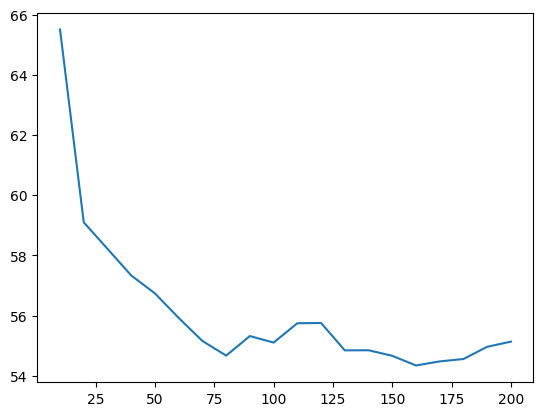

In [53]:
plt.plot(df_scores.n_estimators, df_scores.RMSE)

Answer: n_estimators  = 10

# Question 4
```
Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?
```

In [54]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        RMSE = np.sqrt(np.mean((y_pred - y_val) ** 2))

        scores.append((d, n, RMSE))

In [55]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)

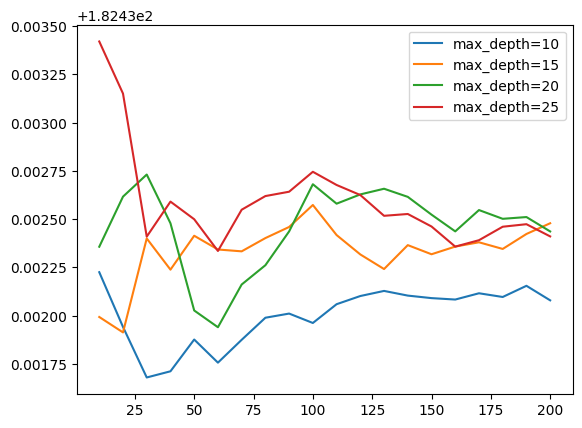

In [58]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.RMSE,
             label='max_depth=%d' % d)

plt.legend()

Best max_depth : 10

## Question 5
```
We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parameters:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature (among these 4)?

study_hours_per_week
attendance_rate
distance_to_school
teacher_quality
```

In [59]:
rf = RandomForestClassifier(n_estimators=10,
                            max_depth=20,
                            random_state=1,
                            n_jobs=-1)
rf.fit(X_train, y_train)

#y_pred = rf.predict_proba(X_val)[:, 1]
#RMSE = np.sqrt(np.mean((y_pred - y_val) ** 2))

RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [61]:
# Get feature importances
importances = rf.feature_importances_

# If you want to pair them with feature names
feature_importance_dict = dict(zip(df_train.columns, importances))

# Sort by importance
sorted_importances = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))
sorted_importances

{'school_location': np.float64(0.115718943995717),
 'school_type': np.float64(0.10695225233734487),
 'teacher_quality': np.float64(0.08456512321452495),
 'distance_to_school': np.float64(0.04367832329843986),
 'socioeconomic_status': np.float64(0.024751584779256514),
 'gender': np.float64(0.024267270284876043),
 'it_knowledge': np.float64(0.02408921419728403),
 'assignments_completed': np.float64(0.02405211094922795),
 'attendance_rate': np.float64(0.02342487616368146),
 'parent_involvement': np.float64(0.023321956078060653),
 'access_to_learning_materials': np.float64(0.02289054949191914),
 'extra_tutorials': np.float64(0.022348715381929375),
 'study_hours_per_week': np.float64(0.020155209181776757),
 'age': np.float64(0.018604034076412472),
 'parent_education_level': np.float64(0.0)}

Answer: teacher_quality

## Question 6
```
Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

0.3
0.1
Both give equal value
```

In [63]:
!pip install xgboost

  Using cached xgboost-2.1.2-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.2-py3-none-win_amd64.whl (124.9 MB)


In [64]:
import xgboost as xgb

In [65]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [70]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [75]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_03 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)

In [76]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model_01 = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=False)

In [79]:
# Get final RMSE for both models
print('model_03', model_03.eval(dval))
print('model_01', model_01.eval(dval))


model_03 [0]	eval-rmse:44.43209802574347123
model_01 [0]	eval-rmse:41.04335453604113582


Answer: eta 0.1 is better